In [1]:
import math
import uproot
from pathlib import Path
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['font.size'] = 12

## Getting the file and tree

In [2]:
# fname = Path("/Users/alexandertuna/Downloads/cms/lst_playing/data/trackingNtuple.2025_04_02_12h00m00s.1muon_0p7gev.root")
fname = Path("/Users/alexandertuna/Downloads/cms/lst_playing/data/trackingNtuple.2025_03_21_11h59m00s.root")
if not fname.exists():
    raise Exception("shit")

In [3]:
file = uproot.open(f"{fname}")
print(file.keys())

['trackingNtuple;1', 'trackingNtuple/tree;14', 'trackingNtuple/tree;13']


In [4]:
tree = uproot.open(f"{fname}:trackingNtuple/tree")
print(tree)

<TTree 'tree' (360 branches) at 0x000120e59be0>


In [5]:
def get_prefixes(col):
    return sorted(list(set([obj.split("_")[0] for obj in col])))
print(get_prefixes(tree.keys()))

['bsp', 'event', 'inv', 'lumi', 'ph2', 'pix', 'run', 'see', 'sim', 'simhit', 'simpv', 'simvtx', 'tcand', 'trk', 'vtx']


## Getting branches into a data array

In [6]:
# print(tree.keys())

In [7]:
data = tree.arrays([
    'simhit_x', 'simhit_y', 'simhit_z',
    'simhit_px', 'simhit_py', 'simhit_pz',
    'simhit_tof', 'simhit_particle', 'simhit_simTrkIdx', 
    'simhit_order', 'simhit_side', 'simhit_layer',
    'simhit_isUpper', 'simhit_isLower',
])
data["simhit_pt"] = np.sqrt(data.simhit_px**2 + data.simhit_py**2)
data["simhit_p"] = np.sqrt(data.simhit_px**2 + data.simhit_py**2 + data.simhit_pz**2)
data["simhit_rt"] = np.sqrt(data.simhit_x**2 + data.simhit_y**2)
data["simhit_cosphi"] = ((data.simhit_x * data.simhit_px) + (data.simhit_y * data.simhit_py)) / (data.simhit_pt * data.simhit_rt)
data["simhit_phi"] = np.atan2(data.simhit_y, data.simhit_x)
data["simhit_isBarrelFlat"] = (data.simhit_order == 0) & (data.simhit_side == 3)

## Plotting

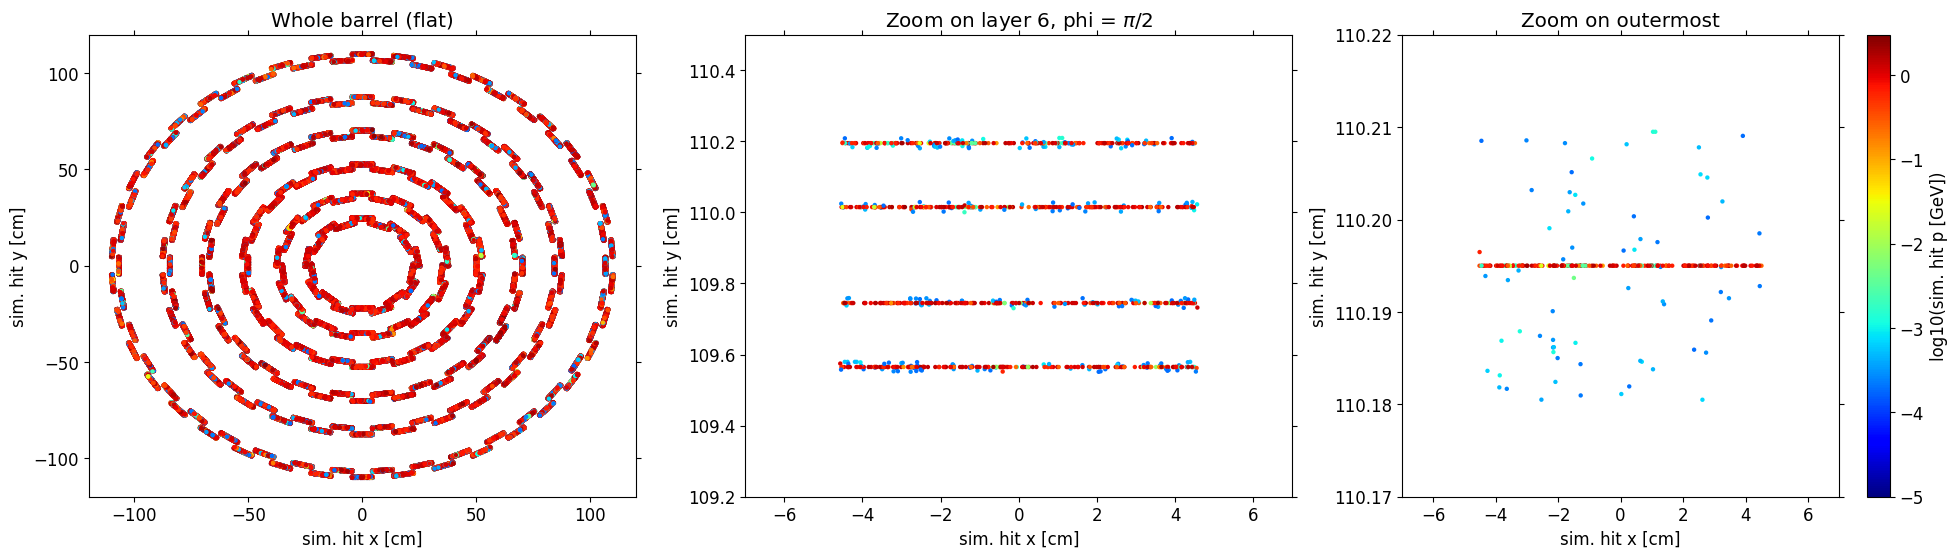

In [8]:
def plot():

    # which hits to plot
    mask = (data.simhit_isBarrelFlat)

    # local variables for less typing
    xs = ak.flatten(data.simhit_x[mask]).to_numpy()
    ys = ak.flatten(data.simhit_y[mask]).to_numpy()
    ps = np.log10(ak.flatten(data.simhit_p[mask]).to_numpy())
    cmap = "jet"
    edgecolors = "none"

    # for visualization, put a limit on very low momentum hits
    min_p = -5
    ps[ps < min_p] = min_p
        
    # create a canvas
    fig, axs = plt.subplots(ncols=3, figsize=(24, 6))

    # whole barrel plot
    xmin, xmax = -120, 120
    ymin, ymax = -120, 120
    axs[0].scatter(xs, ys, s=10, c=ps, edgecolors=edgecolors, cmap=cmap)
    axs[0].set_xlim([xmin, xmax])
    axs[0].set_ylim([ymin, ymax])
    axs[0].set_title(r"Whole barrel (flat)")

    # focus on one phi slice
    xmin, xmax = -7, 7
    ymin, ymax = 109.2, 110.5
    axs[1].scatter(xs, ys, s=10, c=ps, edgecolors=edgecolors, cmap=cmap)
    axs[1].set_xlim([xmin, xmax])
    axs[1].set_ylim([ymin, ymax])
    axs[1].set_title(r"Zoom on layer 6, phi = $\pi/2$")

    # focus on one sensor
    xmin, xmax = -7, 7
    ymin, ymax = 110.17, 110.22
    sc = axs[2].scatter(xs, ys, s=10, c=ps, edgecolors=edgecolors, cmap=cmap)
    axs[2].set_xlim([xmin, xmax])
    axs[2].set_ylim([ymin, ymax])
    axs[2].set_title(r"Zoom on outermost")
    cbar = fig.colorbar(sc, label="log10(sim. hit p [GeV])")

    # common attributes
    for ax in axs:
        ax.set_xlabel("sim. hit x [cm]")
        ax.set_ylabel("sim. hit y [cm]")
        ax.tick_params(right=True, top=True)

plot()

## Check: what are the particles?

In [9]:
def check():

    xmin, xmax = -7, 7
    ymin, ymax = 110.17, 110.22

    # select hits
    mask = \
    (data.simhit_x < xmax) & \
    (data.simhit_x > xmin) & \
    (data.simhit_y < ymax) & \
    (data.simhit_y > ymin) & \
    (data.simhit_isBarrelFlat == True)

    # flatten the arrays
    xs = ak.flatten(data.simhit_x[mask]).to_numpy()
    ys = ak.flatten(data.simhit_y[mask]).to_numpy()
    ps = np.log10(ak.flatten(data.simhit_p[mask]).to_numpy())
    parts = ak.flatten(data.simhit_particle[mask]).to_numpy()

    # make a DF
    df = pd.DataFrame({
        "x [cm]": xs,
        "y [cm]": ys,
        "log(p [GeV])": ps,
        "particle": parts,
    })

    # print low-momentum stuff
    lowpt = df[ df["log(p [GeV])"] < -1]
    print(lowpt.head(n=20))

check()

      x [cm]      y [cm]  log(p [GeV])  particle
2  -2.531440  110.180504     -3.413321        11
4  -2.083214  110.182426     -3.270465        11
6  -2.147200  110.185654     -2.896835        11
7  -2.032097  110.195000     -2.994174        11
8  -2.133978  110.195000     -3.124811        11
11  3.912570  110.209053     -3.733773        11
29  2.736342  110.185593     -3.564123        11
30  2.777002  110.204544     -3.143491        11
37  4.453910  110.192795     -3.651998        11
38  4.443128  110.198502     -3.672617        11
39  4.451962  110.195000     -1.280358       -13
42 -2.843504  110.203186     -3.625024        11
50 -3.877660  110.181831     -3.322999        11
51 -3.863922  110.183136     -3.003559        11
52  2.793138  110.200211     -3.735831        11
55  0.680314  110.184608     -3.133879        11
58 -4.322519  110.193886     -3.488279        11
70 -1.192126  110.201729     -3.519183        11
72 -4.256467  110.183624     -3.182703        11
75 -2.159021  110.18